# Preparing CT colonography data

In [30]:
import pydicom
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image


class DICOMDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        dicom = pydicom.dcmread(self.file_paths[idx])
        image = dicom.pixel_array.astype(np.float32)
        
        if 'RescaleIntercept' in dicom:
            intercept = float(dicom.RescaleIntercept)
            slope = float(dicom.RescaleSlope)
            image = slope * image + intercept
        
       
        image = (image - image.min()) / (image.max() - image.min()) * 255.0
        image = image.astype(np.uint8)
        
       
        image = Image.fromarray(image)
        
       
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        label = self.labels[idx]
        return image, torch.tensor(label, dtype=torch.long)

def prepare_data(data_root, test_size=0.2, val_size=0.1, random_state=42):
    class_folders = {'Negative': 0, '6mm': 1, '10mm': 2}
    file_paths, labels = [], []
    
    for class_name, class_idx in class_folders.items():
        class_dir = os.path.join(data_root, class_name)
        for fname in os.listdir(class_dir):
            if fname.endswith('.dcm'):
                file_paths.append(os.path.join(class_dir, fname))
                labels.append(class_idx)
 
    X_train, X_test, y_train, y_test = train_test_split(
        file_paths, labels, test_size=test_size, random_state=random_state, stratify=labels)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size/(1-test_size), random_state=random_state, stratify=y_train)
    

    train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    

    train_dataset = DICOMDataset(X_train, y_train, train_transform)
    val_dataset = DICOMDataset(X_val, y_val, val_test_transform)
    test_dataset = DICOMDataset(X_test, y_test, val_test_transform)
    
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader

# ResNet model

In [4]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import numpy as np
from itertools import product
import json
import matplotlib.pyplot as plt
from datetime import datetime

class ResNet152:
    def __init__(self, num_classes=3, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.num_classes = num_classes
        self.model = None
        self.optimizer = None
        self.criterion = nn.CrossEntropyLoss()
        self.scheduler = None
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'learning_rate': []
        }
        self.best_val_acc = 0.0
        self.patience_counter = 0
        self.early_stop = False

    def initialize_model(self, lr_fc=1e-3, lr_layer4=1e-4, lr_layer3=1e-5, weight_decay=1e-4):
        """Initialize ResNet-152 with custom learning rates for different layers"""
        self.model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)     
        
        for param in self.model.parameters():
            param.requires_grad = False
            
        
        for param in self.model.layer3.parameters():
            param.requires_grad = True
        for param in self.model.layer4.parameters():
            param.requires_grad = True
        for param in self.model.fc.parameters():
            param.requires_grad = True
          
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, self.num_classes)
        self.model = self.model.to(self.device)
        
        self.optimizer = optim.AdamW([
            {'params': self.model.layer3.parameters(), 'lr': lr_layer3},
            {'params': self.model.layer4.parameters(), 'lr': lr_layer4},
            {'params': self.model.fc.parameters(), 'lr': lr_fc}
        ], weight_decay=weight_decay)
        

        self.scheduler = ReduceLROnPlateau(
            self.optimizer, 
            mode='max', 
            factor=0.1, 
            patience=2, 
            verbose=True
        )

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in tqdm(train_loader, desc='Training'):
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        self.history['train_loss'].append(epoch_loss)
        self.history['train_acc'].append(epoch_acc.item())
        self.history['learning_rate'].append(self.optimizer.param_groups[0]['lr'])
        
        return epoch_loss, epoch_acc

    def validate(self, val_loader):
        """Validate the model"""
        self.model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validating'):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = val_loss / len(val_loader.dataset)
        epoch_acc = val_corrects.double() / len(val_loader.dataset)
        
        self.history['val_loss'].append(epoch_loss)
        self.history['val_acc'].append(epoch_acc.item())
        
        return epoch_loss, epoch_acc

    def check_early_stopping(self, patience=5, min_delta=0.001):
        """Check if early stopping criteria are met"""
        current_acc = self.history['val_acc'][-1]
        
        if current_acc > self.best_val_acc + min_delta:
            self.best_val_acc = current_acc
            self.patience_counter = 0
            return False
        else:
            self.patience_counter += 1
            if self.patience_counter >= patience:
                print(f"\nEarly stopping triggered at epoch {len(self.history['val_acc'])}")
                self.early_stop = True
                return True
            return False

    def train(self, train_loader, val_loader, num_epochs=25, patience=5):
        """Main training loop"""
        for epoch in range(num_epochs):
            print(f'\nEpoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            train_loss, train_acc = self.train_epoch(train_loader)
            val_loss, val_acc = self.validate(val_loader)
            
            self.scheduler.step(val_acc)
            
            print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
            print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
            print(f'Current LR: {self.optimizer.param_groups[0]["lr"]:.2e}')
            
            if val_acc > self.best_val_acc:
                self.save_model('best_resnet152_model.pth')
            
            if self.check_early_stopping(patience=patience):
                break
        
       
        self.load_model('best_resnet152_model.pth')

    def test(self, test_loader):
        """Evaluate on test set"""
        self.model.eval()
        test_loss = 0.0
        test_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc='Testing'):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                test_loss += loss.item() * inputs.size(0)
                test_corrects += torch.sum(preds == labels.data)
        
        test_loss = test_loss / len(test_loader.dataset)
        test_acc = test_corrects.double() / len(test_loader.dataset)
        
        print(f'\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')
        return test_loss, test_acc

    def save_model(self, path):
        """Save model checkpoint"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'history': self.history,
            'best_val_acc': self.best_val_acc
        }, path)

    def load_model(self, path):
        """Load model checkpoint"""
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.history = checkpoint['history']
        self.best_val_acc = checkpoint['best_val_acc']

    def plot_history(self):
        """Plot training history"""
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.history['train_loss'], label='Train Loss')
        plt.plot(self.history['val_loss'], label='Val Loss')
        plt.title('Loss over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(self.history['train_acc'], label='Train Accuracy')
        plt.plot(self.history['val_acc'], label='Val Accuracy')
        plt.title('Accuracy over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()



# hyperparameter tuning

In [6]:
def hyperparameter_tuning(train_loader, val_loader, num_trials=10):
    """Perform hyperparameter tuning with random search"""
    param_grid = {
        'lr_fc': [1e-4, 3e-4, 1e-3],
        'lr_layer4': [1e-5, 3e-5, 1e-4],
        'lr_layer3': [1e-6, 3e-6, 1e-5],
        'weight_decay': [1e-5, 1e-4, 1e-3]
    }
    
    best_params = None
    best_acc = 0.0
    
    print("Starting hyperparameter tuning...")
    
    for trial in range(num_trials):
  
        params = {
            'lr_fc': np.random.choice(param_grid['lr_fc']),
            'lr_layer4': np.random.choice(param_grid['lr_layer4']),
            'lr_layer3': np.random.choice(param_grid['lr_layer3']),
            'weight_decay': np.random.choice(param_grid['weight_decay'])
        }
        
        print(f"\nTrial {trial+1}/{num_trials} | Params: {params}")
        
       
        tuner = ResNet152Tuner(num_classes=3)
        tuner.initialize_model(**params)
        tuner.train(train_loader, val_loader, num_epochs=10)  
        
        current_acc = max(tuner.history['val_acc'])
        
        if current_acc > best_acc:
            best_acc = current_acc
            best_params = params
            print(f"New best accuracy: {best_acc:.4f}")
    
    print(f"\nBest params: {best_params} with val accuracy: {best_acc:.4f}")
    return best_params

Starting hyperparameter tuning...

Trial 1/5 | Params: {'lr_fc': 0.001, 'lr_layer4': 1e-05, 'lr_layer3': 3e-06, 'weight_decay': 0.001}


C:\Users\STEM\AppData\Local\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/10
----------


Training:   9%|██████████████▌                                                                                                                                                   | 6/67 [00:05<00:51,  1.18it/s]C:\Users\STEM\AppData\Local\Temp\ipykernel_9860\4264291964.py:33: RuntimeWarning: invalid value encountered in divide
  image = (image - image.min()) / (image.max() - image.min()) * 255.0
C:\Users\STEM\AppData\Local\Temp\ipykernel_9860\4264291964.py:34: RuntimeWarning: invalid value encountered in cast
  image = image.astype(np.uint8)
Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.38it/s]


Train Loss: 1.0020 | Train Acc: 0.5142
Val Loss: 0.9823 | Val Acc: 0.5446
Current LR: 3.00e-06

Epoch 2/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


Train Loss: 0.7490 | Train Acc: 0.7243
Val Loss: 0.6902 | Val Acc: 0.7261
Current LR: 3.00e-06

Epoch 3/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.37it/s]


Train Loss: 0.5175 | Train Acc: 0.8343
Val Loss: 0.5480 | Val Acc: 0.7789
Current LR: 3.00e-06

Epoch 4/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.37it/s]


Train Loss: 0.3462 | Train Acc: 0.8924
Val Loss: 0.4246 | Val Acc: 0.8284
Current LR: 3.00e-06

Epoch 5/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.38it/s]


Train Loss: 0.2475 | Train Acc: 0.9212
Val Loss: 0.3425 | Val Acc: 0.8614
Current LR: 3.00e-06

Epoch 6/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.36it/s]


Train Loss: 0.1846 | Train Acc: 0.9438
Val Loss: 0.3306 | Val Acc: 0.8647
Current LR: 3.00e-06

Epoch 7/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.37it/s]


Train Loss: 0.1448 | Train Acc: 0.9537
Val Loss: 0.3214 | Val Acc: 0.8647
Current LR: 3.00e-06

Epoch 8/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


Train Loss: 0.1311 | Train Acc: 0.9533
Val Loss: 0.3358 | Val Acc: 0.8911
Current LR: 3.00e-06

Epoch 9/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


Train Loss: 0.1203 | Train Acc: 0.9585
Val Loss: 0.3342 | Val Acc: 0.8746
Current LR: 3.00e-06

Epoch 10/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.37it/s]
C:\Users\STEM\AppData\Local\Temp\ipykernel_9860\4065268479.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any 

Train Loss: 0.1079 | Train Acc: 0.9646
Val Loss: 0.3147 | Val Acc: 0.8812
Current LR: 3.00e-06
New best accuracy: 0.8911

Trial 2/5 | Params: {'lr_fc': 0.001, 'lr_layer4': 1e-05, 'lr_layer3': 1e-06, 'weight_decay': 0.0001}

Epoch 1/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.38it/s]


Train Loss: 0.9999 | Train Acc: 0.5222
Val Loss: 0.9841 | Val Acc: 0.5413
Current LR: 1.00e-06

Epoch 2/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.30it/s]


Train Loss: 0.7865 | Train Acc: 0.6922
Val Loss: 0.7550 | Val Acc: 0.7063
Current LR: 1.00e-06

Epoch 3/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.38it/s]


Train Loss: 0.5796 | Train Acc: 0.8107
Val Loss: 0.6139 | Val Acc: 0.7723
Current LR: 1.00e-06

Epoch 4/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.35it/s]


Train Loss: 0.4196 | Train Acc: 0.8683
Val Loss: 0.5283 | Val Acc: 0.7822
Current LR: 1.00e-06

Epoch 5/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.37it/s]


Train Loss: 0.3094 | Train Acc: 0.9065
Val Loss: 0.4464 | Val Acc: 0.8284
Current LR: 1.00e-06

Epoch 6/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.34it/s]


Train Loss: 0.2299 | Train Acc: 0.9292
Val Loss: 0.4112 | Val Acc: 0.8515
Current LR: 1.00e-06

Epoch 7/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.38it/s]


Train Loss: 0.1930 | Train Acc: 0.9353
Val Loss: 0.3992 | Val Acc: 0.8581
Current LR: 1.00e-06

Epoch 8/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.34it/s]


Train Loss: 0.1535 | Train Acc: 0.9500
Val Loss: 0.3728 | Val Acc: 0.8581
Current LR: 1.00e-06

Epoch 9/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.40it/s]


Train Loss: 0.1419 | Train Acc: 0.9514
Val Loss: 0.3631 | Val Acc: 0.8614
Current LR: 1.00e-06

Epoch 10/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


Train Loss: 0.1246 | Train Acc: 0.9580
Val Loss: 0.3519 | Val Acc: 0.8581
Current LR: 1.00e-06

Trial 3/5 | Params: {'lr_fc': 0.0003, 'lr_layer4': 3e-05, 'lr_layer3': 1e-06, 'weight_decay': 1e-05}

Epoch 1/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


Train Loss: 1.0291 | Train Acc: 0.4901
Val Loss: 0.9996 | Val Acc: 0.5380
Current LR: 1.00e-06

Epoch 2/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.38it/s]


Train Loss: 0.7943 | Train Acc: 0.6903
Val Loss: 0.6949 | Val Acc: 0.7261
Current LR: 1.00e-06

Epoch 3/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.38it/s]


Train Loss: 0.4703 | Train Acc: 0.8503
Val Loss: 0.4698 | Val Acc: 0.7954
Current LR: 1.00e-06

Epoch 4/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.36it/s]


Train Loss: 0.2781 | Train Acc: 0.9084
Val Loss: 0.3617 | Val Acc: 0.8416
Current LR: 1.00e-06

Epoch 5/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


Train Loss: 0.1894 | Train Acc: 0.9344
Val Loss: 0.3357 | Val Acc: 0.8680
Current LR: 1.00e-06

Epoch 6/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.38it/s]


Train Loss: 0.1496 | Train Acc: 0.9457
Val Loss: 0.3237 | Val Acc: 0.8647
Current LR: 1.00e-06

Epoch 7/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


Train Loss: 0.1296 | Train Acc: 0.9495
Val Loss: 0.2976 | Val Acc: 0.8779
Current LR: 1.00e-06

Epoch 8/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


Train Loss: 0.1164 | Train Acc: 0.9585
Val Loss: 0.3192 | Val Acc: 0.8845
Current LR: 1.00e-06

Epoch 9/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.38it/s]


Train Loss: 0.0979 | Train Acc: 0.9613
Val Loss: 0.3357 | Val Acc: 0.8812
Current LR: 1.00e-06

Epoch 10/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


Train Loss: 0.0864 | Train Acc: 0.9684
Val Loss: 0.2944 | Val Acc: 0.8713
Current LR: 1.00e-06

Trial 4/5 | Params: {'lr_fc': 0.0001, 'lr_layer4': 0.0001, 'lr_layer3': 3e-06, 'weight_decay': 0.0001}

Epoch 1/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


Train Loss: 0.9229 | Train Acc: 0.5963
Val Loss: 0.8345 | Val Acc: 0.6304
Current LR: 3.00e-06

Epoch 2/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.32it/s]


Train Loss: 0.3867 | Train Acc: 0.8645
Val Loss: 0.3562 | Val Acc: 0.8416
Current LR: 3.00e-06

Epoch 3/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.37it/s]


Train Loss: 0.1878 | Train Acc: 0.9330
Val Loss: 0.2703 | Val Acc: 0.8581
Current LR: 3.00e-06

Epoch 4/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.38it/s]


Train Loss: 0.1439 | Train Acc: 0.9452
Val Loss: 0.2720 | Val Acc: 0.8779
Current LR: 3.00e-06

Epoch 5/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


Train Loss: 0.1242 | Train Acc: 0.9500
Val Loss: 0.2474 | Val Acc: 0.8779
Current LR: 3.00e-06

Epoch 6/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.37it/s]


Train Loss: 0.1066 | Train Acc: 0.9575
Val Loss: 0.2476 | Val Acc: 0.8977
Current LR: 3.00e-06

Epoch 7/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.35it/s]


Train Loss: 0.0846 | Train Acc: 0.9665
Val Loss: 0.2823 | Val Acc: 0.8911
Current LR: 3.00e-06

Epoch 8/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.30it/s]


Train Loss: 0.0793 | Train Acc: 0.9726
Val Loss: 0.2849 | Val Acc: 0.9043
Current LR: 3.00e-06

Epoch 9/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.37it/s]


Train Loss: 0.0586 | Train Acc: 0.9764
Val Loss: 0.2829 | Val Acc: 0.9010
Current LR: 3.00e-06

Epoch 10/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.38it/s]


Train Loss: 0.0655 | Train Acc: 0.9769
Val Loss: 0.3865 | Val Acc: 0.8878
Current LR: 3.00e-06
New best accuracy: 0.9043

Trial 5/5 | Params: {'lr_fc': 0.001, 'lr_layer4': 0.0001, 'lr_layer3': 1e-05, 'weight_decay': 1e-05}

Epoch 1/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.36it/s]


Train Loss: 0.8164 | Train Acc: 0.6308
Val Loss: 0.7860 | Val Acc: 0.6370
Current LR: 1.00e-05

Epoch 2/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.33it/s]


Train Loss: 0.2505 | Train Acc: 0.9065
Val Loss: 0.3180 | Val Acc: 0.8614
Current LR: 1.00e-05

Epoch 3/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


Train Loss: 0.1511 | Train Acc: 0.9410
Val Loss: 0.2459 | Val Acc: 0.8911
Current LR: 1.00e-05

Epoch 4/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.38it/s]


Train Loss: 0.1024 | Train Acc: 0.9651
Val Loss: 0.2510 | Val Acc: 0.8779
Current LR: 1.00e-05

Epoch 5/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


Train Loss: 0.0816 | Train Acc: 0.9674
Val Loss: 0.2713 | Val Acc: 0.8779
Current LR: 1.00e-05

Epoch 6/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.22it/s]


Train Loss: 0.0699 | Train Acc: 0.9712
Val Loss: 0.2642 | Val Acc: 0.8944
Current LR: 1.00e-05

Epoch 7/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


Train Loss: 0.0698 | Train Acc: 0.9745
Val Loss: 0.2775 | Val Acc: 0.8812
Current LR: 1.00e-05

Epoch 8/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.15it/s]


Train Loss: 0.0475 | Train Acc: 0.9792
Val Loss: 0.3114 | Val Acc: 0.8977
Current LR: 1.00e-05

Epoch 9/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.33it/s]


Train Loss: 0.0593 | Train Acc: 0.9731
Val Loss: 0.3215 | Val Acc: 0.8878
Current LR: 1.00e-05

Epoch 10/10
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.33it/s]


Train Loss: 0.0586 | Train Acc: 0.9759
Val Loss: 0.3412 | Val Acc: 0.8812
Current LR: 1.00e-05

Best params: {'lr_fc': 0.0001, 'lr_layer4': 0.0001, 'lr_layer3': 3e-06, 'weight_decay': 0.0001} with val accuracy: 0.9043

Epoch 1/20
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.33it/s]


Train Loss: 0.9285 | Train Acc: 0.5765
Val Loss: 0.8644 | Val Acc: 0.6337
Current LR: 3.00e-06

Epoch 2/20
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.33it/s]


Train Loss: 0.3794 | Train Acc: 0.8843
Val Loss: 0.3213 | Val Acc: 0.8416
Current LR: 3.00e-06

Epoch 3/20
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


Train Loss: 0.1978 | Train Acc: 0.9254
Val Loss: 0.2580 | Val Acc: 0.8680
Current LR: 3.00e-06

Epoch 4/20
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.41it/s]


Train Loss: 0.1536 | Train Acc: 0.9429
Val Loss: 0.2304 | Val Acc: 0.8911
Current LR: 3.00e-06

Epoch 5/20
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


Train Loss: 0.1199 | Train Acc: 0.9523
Val Loss: 0.2648 | Val Acc: 0.9076
Current LR: 3.00e-06

Epoch 6/20
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.40it/s]


Train Loss: 0.1028 | Train Acc: 0.9603
Val Loss: 0.2466 | Val Acc: 0.9076
Current LR: 3.00e-06

Epoch 7/20
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.40it/s]


Train Loss: 0.0956 | Train Acc: 0.9613
Val Loss: 0.2386 | Val Acc: 0.9208
Current LR: 3.00e-06

Epoch 8/20
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


Train Loss: 0.0545 | Train Acc: 0.9783
Val Loss: 0.3145 | Val Acc: 0.8977
Current LR: 3.00e-06

Epoch 9/20
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.38it/s]


Train Loss: 0.0652 | Train Acc: 0.9745
Val Loss: 0.2870 | Val Acc: 0.9010
Current LR: 3.00e-06

Epoch 10/20
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.38it/s]


Train Loss: 0.0431 | Train Acc: 0.9825
Val Loss: 0.3226 | Val Acc: 0.9076
Current LR: 3.00e-07

Epoch 11/20
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.38it/s]


Train Loss: 0.0355 | Train Acc: 0.9830
Val Loss: 0.3308 | Val Acc: 0.9109
Current LR: 3.00e-07

Epoch 12/20
----------


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]


Train Loss: 0.0340 | Train Acc: 0.9844
Val Loss: 0.3410 | Val Acc: 0.9142
Current LR: 3.00e-07

Early stopping triggered at epoch 12


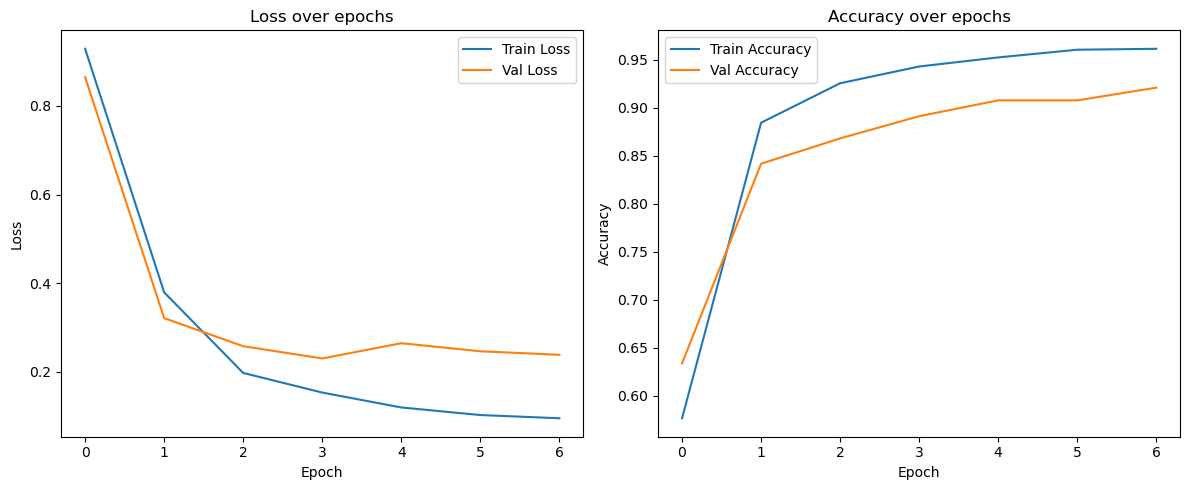

Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:09<00:00,  1.96it/s]



Test Loss: 0.1905 | Test Acc: 0.9356

Training complete. Test Accuracy: 0.9356


In [6]:
def main():
   
    data_root = r'C:\Users\stem\Downloads\data\data'
    train_loader, val_loader, test_loader = prepare_data(data_root)
    
    best_params = hyperparameter_tuning(train_loader, val_loader, num_trials=5)
    
    trainer = ResNet152Tuner(num_classes=3)
    trainer.initialize_model(**best_params)

    trainer.train(train_loader, val_loader, num_epochs=20, patience=5)

    trainer.plot_history()
    
    test_loss, test_acc = trainer.test(test_loader)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    trainer.save_model(f'resnet152_final_{timestamp}.pth')
    
    results = {
        'best_params': best_params,
        'test_accuracy': test_acc.item(),
        'training_history': trainer.history
    }
    
    with open(f'training_results_{timestamp}.json', 'w') as f:
        json.dump(results, f, indent=4)
    
    print(f"\nTraining complete. Test Accuracy: {test_acc:.4f}")

if __name__ == '__main__':
    main()

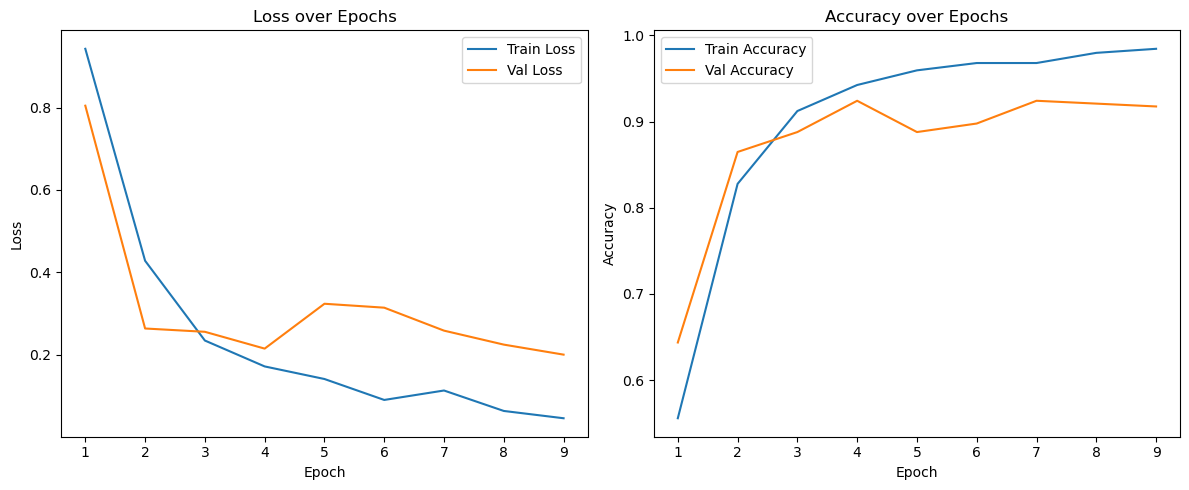

In [53]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Model evaluation

In [10]:
import torch
import torchvision.models as models
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, 
                             precision_recall_curve, roc_curve, auc, 
                             average_precision_score)
from tqdm import tqdm
import pandas as pd
import json
from datetime import datetime

def evaluate_model(model, test_loader, device='cuda', class_names=None):

    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
  
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
         
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
        
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    plot_confusion_matrix(all_labels, all_preds, class_names)

    plot_roc_curves(all_labels, all_probs, class_names)

    plot_precision_recall_curves(all_labels, all_probs, class_names)

    display_additional_metrics(all_labels, all_preds, all_probs, class_names)

    save_results(all_labels, all_preds, all_probs, class_names)
    
    return all_labels, all_preds, all_probs

# Visualization functions

In [12]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot a detailed confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  
    
    plt.figure(figsize=(10, 8))
    
    plt.subplot(2, 1, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Counts)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.subplot(2, 1, 2)
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Normalized)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()


In [14]:
def plot_roc_curves(y_true, y_probs, class_names):
    """Plot ROC curves for each class"""
    n_classes = len(class_names)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(
        np.eye(n_classes)[y_true].ravel(), y_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown'][:n_classes]
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(class_names[i], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

In [16]:
def plot_precision_recall_curves(y_true, y_probs, class_names):
    """Plot precision-recall curves for each class"""
    n_classes = len(class_names)
    
    precision = dict()
    recall = dict()
    average_precision = dict()
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(
            (y_true == i).astype(int), y_probs[:, i])
        average_precision[i] = average_precision_score(
            (y_true == i).astype(int), y_probs[:, i])

    precision["micro"], recall["micro"], _ = precision_recall_curve(
        np.eye(n_classes)[y_true].ravel(), y_probs.ravel())
    average_precision["micro"] = average_precision_score(
        np.eye(n_classes)[y_true], y_probs, average="micro")

    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown'][:n_classes]
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label='Precision-recall for class {0} (AP = {1:0.2f})'
                 ''.format(class_names[i], average_precision[i]))
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curves')
    plt.legend(loc="lower left")
    plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches='tight')
    plt.show()


In [18]:
def display_additional_metrics(y_true, y_pred, y_probs, class_names):
    """Calculate and display additional performance metrics"""
    from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, log_loss
    
    accuracy = np.mean(y_true == y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    loss = log_loss(y_true, y_probs)
    
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Cohen Kappa', 'Matthews Correlation', 'Log Loss'],
        'Value': [accuracy, kappa, mcc, loss]
    })
    
    print("\nAdditional Metrics:")
    print(metrics_df.to_string(index=False))
    
    class_metrics = []
    for i, class_name in enumerate(class_names):
        class_mask = (y_true == i)
        class_acc = np.mean(y_pred[class_mask] == y_true[class_mask])
        class_precision = np.mean(y_pred[y_pred == i] == y_true[y_pred == i])
        class_recall = np.mean(y_pred[y_true == i] == y_true[y_true == i])
        
        class_metrics.append({
            'Class': class_name,
            'Accuracy': class_acc,
            'Precision': class_precision,
            'Recall': class_recall
        })
    
    class_metrics_df = pd.DataFrame(class_metrics)
    print("\nClass-wise Metrics:")
    print(class_metrics_df.to_string(index=False))

In [20]:
def save_results(y_true, y_pred, y_probs, class_names):
    """Save all evaluation results to files"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    results_df = pd.DataFrame({
        'True_Label': [class_names[i] for i in y_true],
        'Predicted_Label': [class_names[i] for i in y_pred],
        **{f'Prob_{class_names[i]}': y_probs[:, i] for i in range(len(class_names))}
    })
    
    results_df.to_csv(f'predictions_{timestamp}.csv', index=False)
    
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    with open(f'metrics_{timestamp}.json', 'w') as f:
        json.dump(report, f, indent=4)


In [22]:
def visualize_predictions(model, test_loader, device='cuda', class_names=None, num_samples=5):
    """Visualize model predictions on sample images"""
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    inputs, labels = next(iter(test_loader))
    inputs, labels = inputs.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
    
    inputs = inputs.cpu().numpy()
    labels = labels.cpu().numpy()
    preds = preds.cpu().numpy()
    probs = probs.cpu().numpy()
    
    plt.figure(figsize=(15, 10))
    for i in range(min(num_samples, len(inputs))):
        plt.subplot(1, num_samples, i+1)
        img = np.transpose(inputs[i], (1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min())  
        
        plt.imshow(img)
        true_label = class_names[labels[i]]
        pred_label = class_names[preds[i]]
        prob = probs[i][preds[i]]
        
        title = f'True: {true_label}\nPred: {pred_label}\nProb: {prob:.2f}'
        if pred_label == true_label:
            plt.title(title, color='green')
        else:
            plt.title(title, color='red')
        
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()


In [24]:
def load_model(model_path, num_classes=3, device='cuda'):
    """Load a trained ResNet-152 model"""
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    
    model = models.resnet152(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)

    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model

In [26]:
def prepare_data(data_root, test_size=0.2, val_size=0.1, random_state=42):
    class_folders = {'Negative': 0, '6mm': 1, '10mm': 2}
    file_paths, labels = [], []
    
    for class_name, class_idx in class_folders.items():
        class_dir = os.path.join(data_root, class_name)
        for fname in os.listdir(class_dir):
            if fname.endswith('.dcm'):
                file_paths.append(os.path.join(class_dir, fname))
                labels.append(class_idx)
    
    X_train, X_test, y_train, y_test = train_test_split(
        file_paths, labels, test_size=test_size, random_state=random_state, stratify=labels)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size/(1-test_size), random_state=random_state, stratify=y_train)

    train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    

    train_dataset = DICOMDataset(X_train, y_train, train_transform)
    val_dataset = DICOMDataset(X_val, y_val, val_test_transform)
    test_dataset = DICOMDataset(X_test, y_test, val_test_transform)
    
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader

C:\Users\User\AppData\Local\Temp\ipykernel_15744\1886816365.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
Eva


Classification Report:
              precision    recall  f1-score   support

      Normal       0.91      0.94      0.93       241
      Benign       0.91      0.86      0.89       197
   Malignant       0.91      0.94      0.93       168

    accuracy                           0.91       606
   macro avg       0.91      0.91      0.91       606
weighted avg       0.91      0.91      0.91       606



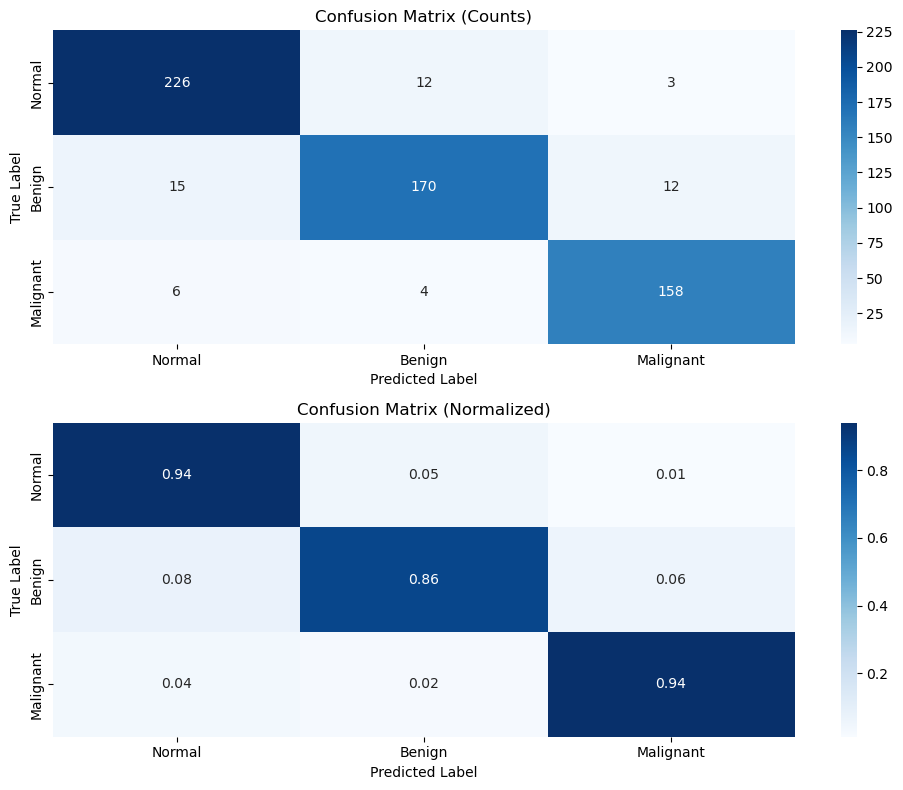

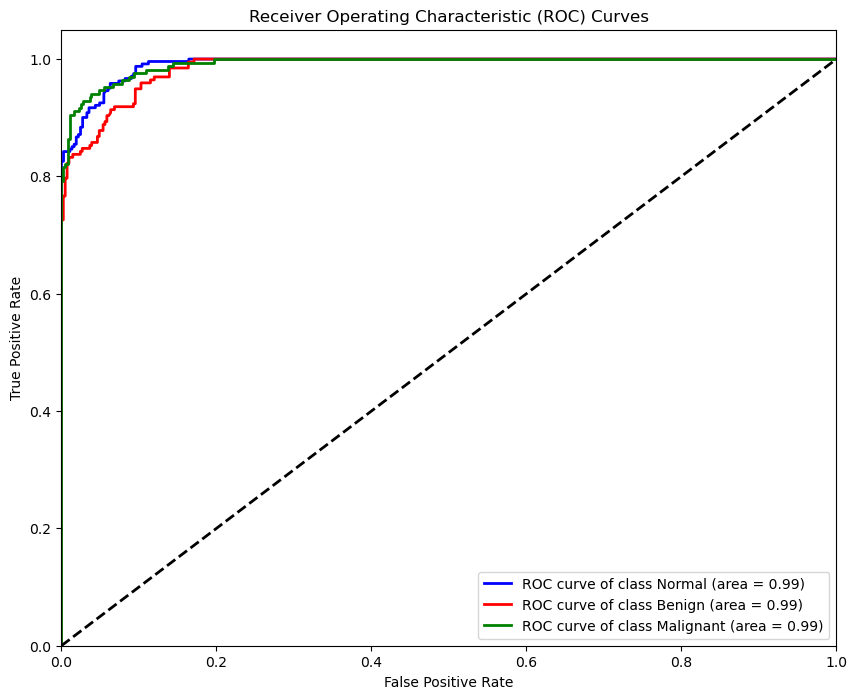

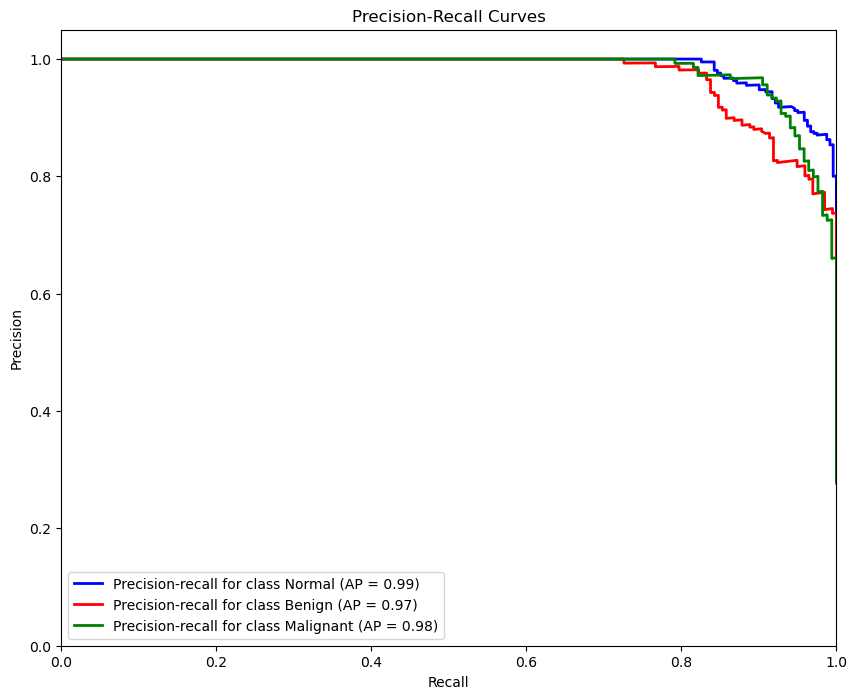


Additional Metrics:
              Metric    Value
            Accuracy 0.914191
         Cohen Kappa 0.869787
Matthews Correlation 0.870114
            Log Loss 0.195112

Class-wise Metrics:
    Class  Accuracy  Precision   Recall
   Normal  0.937759   0.914980 0.937759
   Benign  0.862944   0.913978 0.862944
Malignant  0.940476   0.913295 0.940476


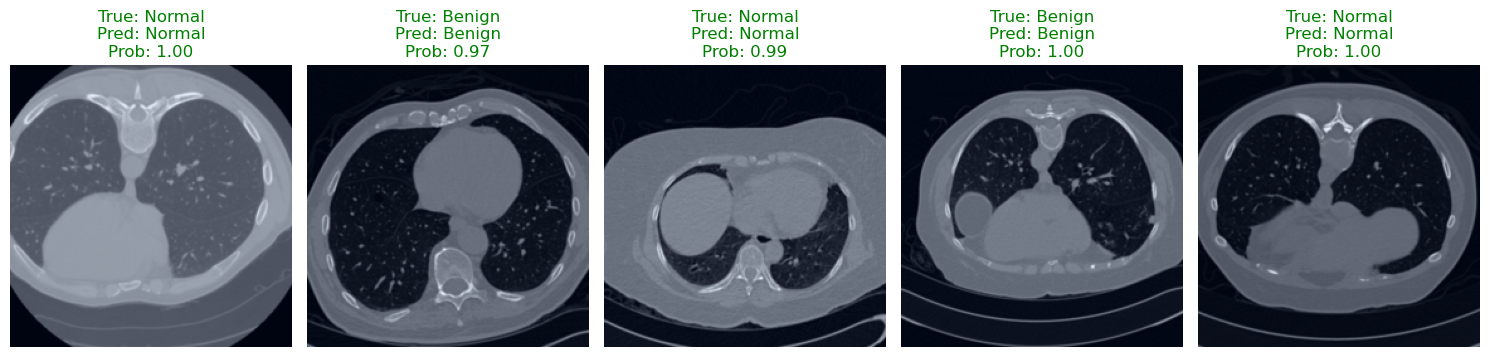

In [36]:
def main():
   
    class_names = ['Normal', 'Benign', 'Malignant'] 
    
    data_root = r'C:\Users\User\Desktop\data'  
    
    model_path = 'best_resnet152_model.pth'  
    model = load_model(model_path, num_classes=len(class_names))

    _, _, test_loader = prepare_data(data_root)
    
    y_true, y_pred, y_probs = evaluate_model(model, test_loader, class_names=class_names)
    
    visualize_predictions(model, test_loader, class_names=class_names, num_samples=5)

if __name__ == '__main__':
    main()